In [1]:
###################
# I Initialization
###################

#+++++++++++++++
# Load libraries
#+++++++++++++++

import os
from pathlib import Path # for path in Windows and Unix
import zipfile
import numpy as np
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import glob
import matplotlib.pyplot as plt
from matplotlib import pyplot
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.inspection import permutation_importance
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier

#+++++++++++++++++++
# Define Environment
#++++++++++++++++++

environemnt = 'kaggle'

#+++++++++++++++++++++++++++
# Define the working folders
#+++++++++++++++++++++++++++

# see https://careerkarma.com/blog/python-list-files-in-directory/
# See https://medium.com/@ageitgey/python-3-quick-tip-the-easy-way-to-deal-with-file-paths-on-windows-mac-and-linux-11a072b58d5f

if environemnt == 'kaggle':
    project_data_folder = Path('/kaggle/input/beta-lactamase-001-data-wrangling-and-eda/')
if environemnt == 'local':
    project_data_folder = Path('/home/will/Documents//Python/Beta_lactamase/Data/')
if environemnt == 'colab':
    project_data_folder = Path('/content/drive/MyDrive/Bioinformatics/Beta-lactamase/Data/')
    
#++++++++++++++++++++++++
# Load the processed data
#++++++++++++++++++++++++

file_path = project_data_folder / 'beta-lactamase_filtered_dataset.csv'
df = pd.read_csv(file_path)
df.head()

,molecule_chembl_id,canonical_smiles,standard_relation,standard_value,standard_units,standard_type,pchembl_value,target_pref_name,bao_label,Name,...,SubFP298,SubFP299,SubFP300,SubFP301,SubFP302,SubFP303,SubFP304,SubFP305,SubFP306,SubFP307
0,CHEMBL1401836,COc1ccc(CCNC(=O)CSCc2ccc(F)cc2)cc1OC,=,79432.8,nM,Potency,4.10,Beta-lactamase AmpC,assay format,CHEMBL1401836,...,0,0,1,1,1,0,0,0,0,1
1,CHEMBL554891,Cl.c1ccc(C2CN3CCSC3=N2)cc1,=,631.0,nM,Potency,6.20,Beta-lactamase AmpC,assay format,CHEMBL554891,...,0,0,1,1,1,0,0,0,0,1
2,CHEMBL1519543,CCOc1ccc(CCNC(=O)Cn2ncn3c(cc4ccccc43)c2=O)cc1OCC,=,631.0,nM,Potency,6.20,Beta-lactamase AmpC,assay format,CHEMBL1519543,...,0,0,1,1,1,0,0,0,0,1
3,CHEMBL1401837,O=C(Nc1ccc2c(c1)OCO2)c1cc(C2CC2)on1,=,5623.4,nM,Potency,5.25,Beta-lactamase AmpC,assay format,CHEMBL1401837,...,0,0,1,1,1,0,0,0,0,1
4,CHEMBL2369239,CCCCCCOc1ccc(N2C(=O)CC(SC(=N)N/N=C(\C)c3cccs3)...,=,63095.7,nM,Potency,4.20,Beta-lactamase AmpC,assay format,CHEMBL2369239,...,0,0,1,1,1,0,0,0,0,1


In [2]:
#####################
# II Data Preparation
#####################

#+++++++++++++++++++
# Feature enginering
#+++++++++++++++++++

# Drop content no useful for prediction
# canonical_smiles, standard_relation, standard_value, standard_units, 
# standard_type, target_pref_name, bao_label

columns_to_drop = ['canonical_smiles', 'standard_relation', 'standard_value', 'standard_units', 
                   'standard_type', 'target_pref_name', 'bao_label', 'Name', 'molecule_chembl_id']
df1 = df.drop(columns_to_drop, axis = 1)

# Recode pchembl_value	
# pChEMBL values <5 == 'Inactive' pChEMBL values > 6 == 'Active' pChEMBL values 5-6 == 'Intermediate'
# Inactive = 0
# Intermediate = 1
# Active = 2

def pchembl_value_encoding(pchembl_value):
    if pchembl_value < 5:
        return 'Inactive'
    elif pchembl_value > 5 and pchembl_value < 6:
        return 'Intermediate'
    else:
        return 'Active'

df1['pchembl_value_code'] = df1.apply(lambda row : pchembl_value_encoding(row['pchembl_value']), axis = 1)

df1 = df1.drop(['pchembl_value'], axis = 1)
df1.head()

,SubFP1,SubFP2,SubFP3,SubFP4,SubFP5,SubFP6,SubFP7,SubFP8,SubFP9,SubFP10,...,SubFP299,SubFP300,SubFP301,SubFP302,SubFP303,SubFP304,SubFP305,SubFP306,SubFP307,pchembl_value_code
0,0,1,0,0,0,0,0,0,0,0,...,0,1,1,1,0,0,0,0,1,Inactive
1,0,0,0,0,0,0,0,0,0,0,...,0,1,1,1,0,0,0,0,1,Active
2,1,1,0,0,0,0,0,0,0,0,...,0,1,1,1,0,0,0,0,1,Active
3,0,1,1,0,0,0,0,0,0,0,...,0,1,1,1,0,0,0,0,1,Intermediate
4,1,1,0,0,0,0,0,0,0,0,...,0,1,1,1,0,0,0,0,1,Inactive


In [3]:
#++++++++++++++++++++++++++++++++++++++++++++
# Exclude molecule with intermediate activity
#++++++++++++++++++++++++++++++++++++++++++++

# see https://www.kaggle.com/sayalaruano/eda-fingerprint-calc-binary-classifiers/comments

df1 = df1[df1['pchembl_value_code'] != 'Intermediate']

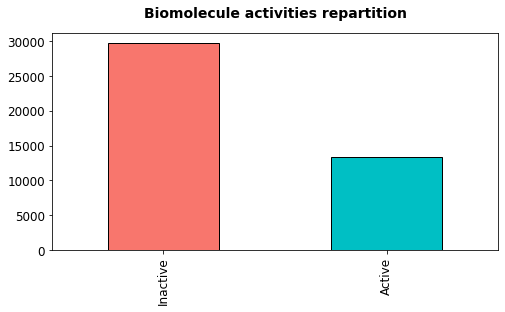

In [4]:
#+++++++++++++++++++++++
# activities repartition
#+++++++++++++++++++++++

pchembl_value_code = df1.pchembl_value_code.value_counts()
pchembl_value_code.plot.bar(figsize=(8,4), color = ['#F8766D', '#00BFC4'], ec='black')

plt.title('Biomolecule activities repartition', fontsize=14, fontweight='black', pad=15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

In [5]:
#+++++++++++++++++++++++++++++++++++++++++
# Split data into input and output objects
#+++++++++++++++++++++++++++++++++++++++++

from sklearn.utils import shuffle

X = df1.drop(['pchembl_value_code'], axis = 1)
y = df1['pchembl_value_code']
X, y = shuffle(X, y)

In [6]:
#++++++++++++++++++++++++++++++
# Remove low variance features
#++++++++++++++++++++++++++++++

# See https://dataprofessor.github.io/ds/bioinformatics/cheminformatics/padelpy/scikit-learn/2021/07/06/_07_06_padelpy.html#Load-HCV-dataset

from sklearn.feature_selection import VarianceThreshold

def remove_low_variance(input_data, threshold=0.1):
    selection = VarianceThreshold(threshold)
    selection.fit(input_data)
    return input_data[input_data.columns[selection.get_support(indices=True)]]

X = remove_low_variance(X, threshold=0.1)
X

,SubFP1,SubFP2,SubFP3,SubFP18,SubFP23,SubFP26,SubFP85,SubFP88,SubFP96,SubFP100,...,SubFP137,SubFP143,SubFP171,SubFP180,SubFP181,SubFP182,SubFP183,SubFP184,SubFP214,SubFP287
28377,1,0,0,0,0,0,1,1,1,0,...,0,1,0,1,1,0,0,1,0,1
23548,0,0,0,0,1,0,0,1,0,1,...,1,0,0,1,1,0,0,1,0,1
26105,1,0,0,1,1,0,0,1,0,1,...,1,0,0,0,0,0,0,0,0,1
15320,0,0,0,1,0,0,0,0,1,0,...,1,0,0,0,1,1,0,1,0,1
14424,0,1,1,0,0,0,0,1,0,0,...,0,0,0,0,1,0,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21653,1,0,0,0,0,0,1,1,0,0,...,1,0,0,0,1,0,0,1,1,1
59946,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,1,0,1,1,0,0
25386,0,1,0,1,0,0,0,0,0,0,...,1,0,0,1,1,0,0,1,0,1
47338,1,0,0,0,0,0,0,0,0,0,...,1,1,0,0,0,1,0,1,1,1


In [7]:
#+++++++++++++++++++++++++++++++++++++++
# Split data into training and test sets
#+++++++++++++++++++++++++++++++++++++++

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42, stratify=y)

#++++++++++++++++++++++++++++++++++++++++++++++++++++++
# Apply SMOTE resampling to correct for class unbalance
#++++++++++++++++++++++++++++++++++++++++++++++++++++++

sm = SMOTE(random_state = 42)
X_train, y_train = sm.fit_resample(X_train, y_train.ravel())

# Apply SMOTE resampling to correct for class unbalance
sm = SMOTE(random_state = 42)
X_train, y_train = sm.fit_resample(X_train, y_train.ravel())

In [8]:
###########################################
# III Spot Check Algorithms in the pipeline
###########################################

# See https://www.kaggle.com/gautham11/building-a-scikit-learn-classification-pipeline
# See https://machinelearningmastery.com/python-machine-learning-mini-course/

# Test options and evaluation metric
num_folds = 10
seed = 7
scoring = 'accuracy'

models = []
models.append(('LR', LogisticRegression()))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC(gamma='auto')))
models.append(('RFC', RandomForestClassifier()))
models.append(('GB', GradientBoostingClassifier()))

results = []
names = []
for name, model in models:
	kfold = KFold(n_splits=num_folds, random_state=seed, shuffle=True)
	cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
	results.append(cv_results)
	names.append(name)
	msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
	print(msg)

LR: 0.539313 (0.006590)
LDA: 0.539355 (0.006680)
KNN: 0.569634 (0.006012)
CART: 0.613654 (0.008547)
NB: 0.533514 (0.007451)
SVM: 0.547172 (0.007404)
RFC: 0.626177 (0.005938)
GB: 0.546962 (0.004960)


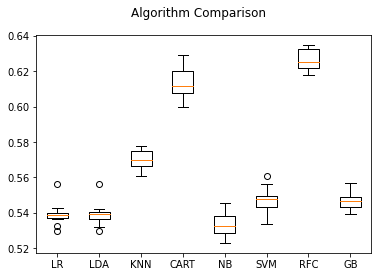

In [9]:
# Compare Algorithms
fig = pyplot.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
pyplot.boxplot(results)
ax.set_xticklabels(names)
pyplot.show()

# References
* https://www.kaggle.com/gautham11/building-a-scikit-learn-classification-pipeline
* https://stackabuse.com/gradient-boosting-classifiers-in-python-with-scikit-learn/